In [ ]:
!pip install yfinance -q
!pip install pmdarima -q

     |████████████████████████████████| 62 kB 804 kB/s 
     |████████████████████████████████| 1.4 MB 13.8 MB/s 
     |████████████████████████████████| 9.8 MB 26.5 MB/s 


In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from numpy import sqrt
from pandas.plotting import autocorrelation_plot
import numpy as np
import pandas as pd

import pmdarima as pm
from pmdarima.model_selection import train_test_split

import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.ticker as mtick
plt.style.use('seaborn')

In [ ]:
import seaborn as sns
import matplotlib as mpl

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

print(mpl.__version__)  
print(sns.__version__)
%matplotlib inline

3.2.2
0.11.2


In [ ]:
df = pd.DataFrame(yf.Ticker('^GSPC').history(period="max"))
df['date'] = df.index
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date
Date,,,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,0,0,1950-01-03
1950-01-04,16.85,16.85,16.85,16.85,1890000,0,0,1950-01-04
1950-01-05,16.93,16.93,16.93,16.93,2550000,0,0,1950-01-05
1950-01-06,16.98,16.98,16.98,16.98,2010000,0,0,1950-01-06
1950-01-09,17.08,17.08,17.08,17.08,2520000,0,0,1950-01-09


In [ ]:
sp500Month = df.Close
sp500Month.index = pd.to_datetime(df.index)
sp500Month = sp500Month.resample('1M').mean()

In [ ]:
def adf_test(dataset):
	result = adfuller(dataset)
	print(f'1. ADF Statistic: {result[0]}')
	print(f'2. p-value: {result[1]}')
	print(f'3. Num of lags: {result[2]}')
	print(f'4. Num of observarions used for ADF regression and Critical values calculation: {result[3]}')
	print(f'5. Critical Values:')
	for key, value in result[4].items():
		print(f'{key}: {value}')

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


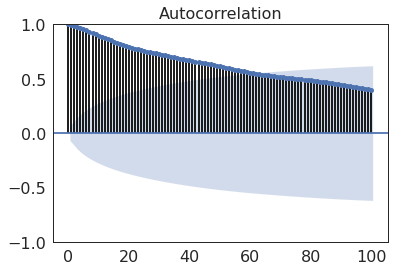

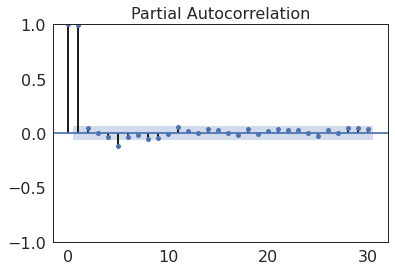

In [ ]:
plot_acf(sp500Month, lags=100);
plot_pacf(sp500Month);

In [ ]:
adf_test(sp500Month)

1. ADF Statistic: 3.570177017995874
2. p-value: 1.0
3. Num of lags: 20
4. Num of observarions used for ADF regression and Critical values calculation: 851
5. Critical Values:
1%: -3.438057561354894
5%: -2.864942268638857
10%: -2.5685816343390853


In [ ]:
diff = sp500Month.diff()

In [ ]:
diff = diff[1:]

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


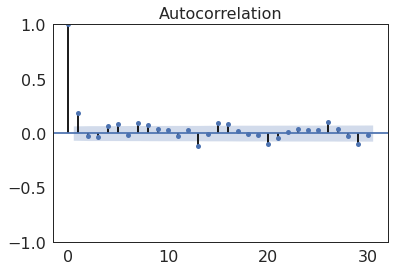

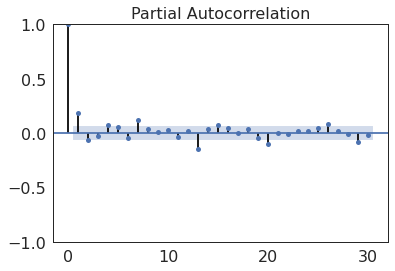

In [ ]:
plot_acf(diff);
plot_pacf(diff);

**PRE DIFERENCIRANJA VREDNOSTI**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


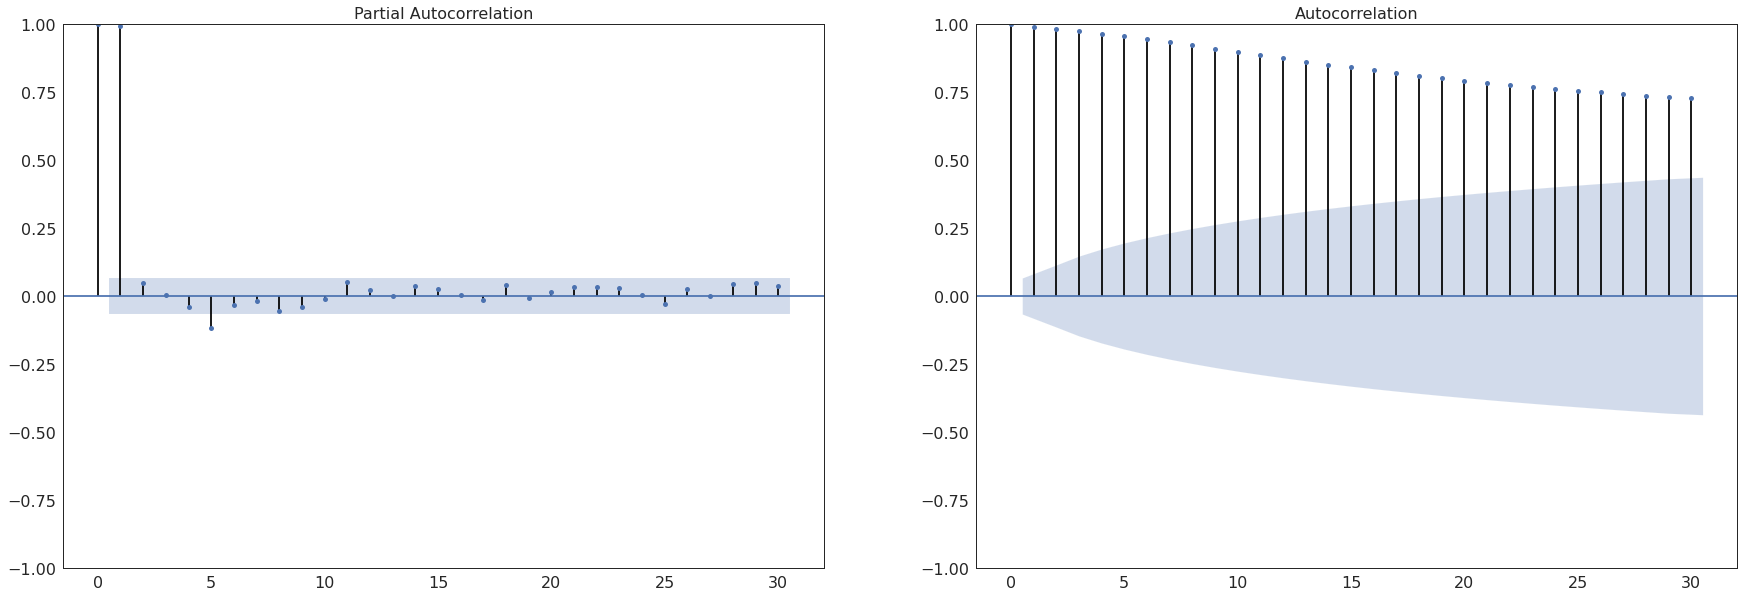

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

plot_pacf(sp500Month ,ax=ax1)
plot_acf(sp500Month,ax=ax2)

fig.show()

**POSLE DIFERENCIRANJA**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


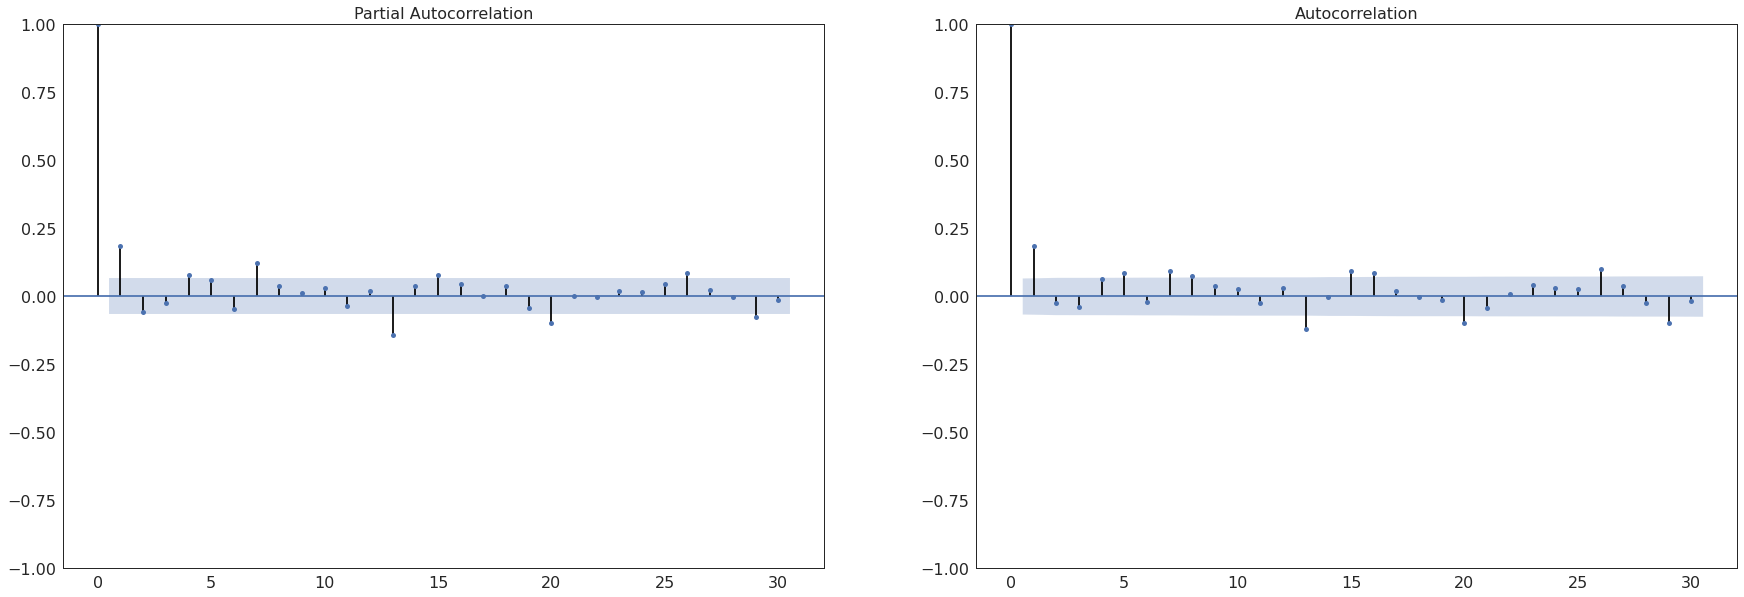

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
plot_pacf(diff,ax=ax1)
plot_acf(diff,ax=ax2)
fig.show()

In [ ]:
adf_test(diff)

1. ADF Statistic: -6.280044649283012
2. p-value: 3.816175839947266e-08
3. Num of lags: 19
4. Num of observarions used for ADF regression and Critical values calculation: 851
5. Critical Values:
1%: -3.438057561354894
5%: -2.864942268638857
10%: -2.5685816343390853


In [ ]:
from scipy.stats import boxcox

def doBoxCox(df):
  val, lam = boxcox(df)
  return val, lam

In [ ]:
coxed = doBoxCox(sp500Month)

In [ ]:
prices = coxed[0] 
lmb = coxed[1] 

In [ ]:
prices = pd.DataFrame(prices, index= sp500Month.index)

In [ ]:
from scipy.special import boxcox, inv_boxcox
values = inv_boxcox(coxed[0], coxed[1])

In [ ]:
train_size = int(len(prices) * 0.9) 
train, test = train_test_split(prices, train_size=train_size)

In [ ]:
model = pm.auto_arima(train, test='adf', trace=True, supress_warnings=True, start_p=0, start_q=0, m=12, d=None, seasonal=True, start_P=0, D=0, stepwise=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-3434.408, Time=2.83 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-3436.347, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-3480.097, Time=1.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-3483.707, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-3413.803, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-3485.706, Time=0.91 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-3483.705, Time=1.58 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-3481.711, Time=6.39 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-3483.777, Time=2.22 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-3483.764, Time=1.94 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-3482.084, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-3480.827, Time=1.40 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-3471.333, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 21.071 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  784
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1745.853
Date:                Thu, 18 Aug 2022   AIC                          -3485.706
Time:                        11:16:12   BIC                          -3471.717
Sample:                             0   HQIC                         -3480.327
                                - 784                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0048      0.001      3.775      0.000       0.002       0.007
ma.L1          0.2625      0.030      8.817      0.000       0.204       0.321
sigma2         0.0007   2.36e-05     28.714      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               318.13
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.69
Prob(H) (two-sided):                  0.51   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

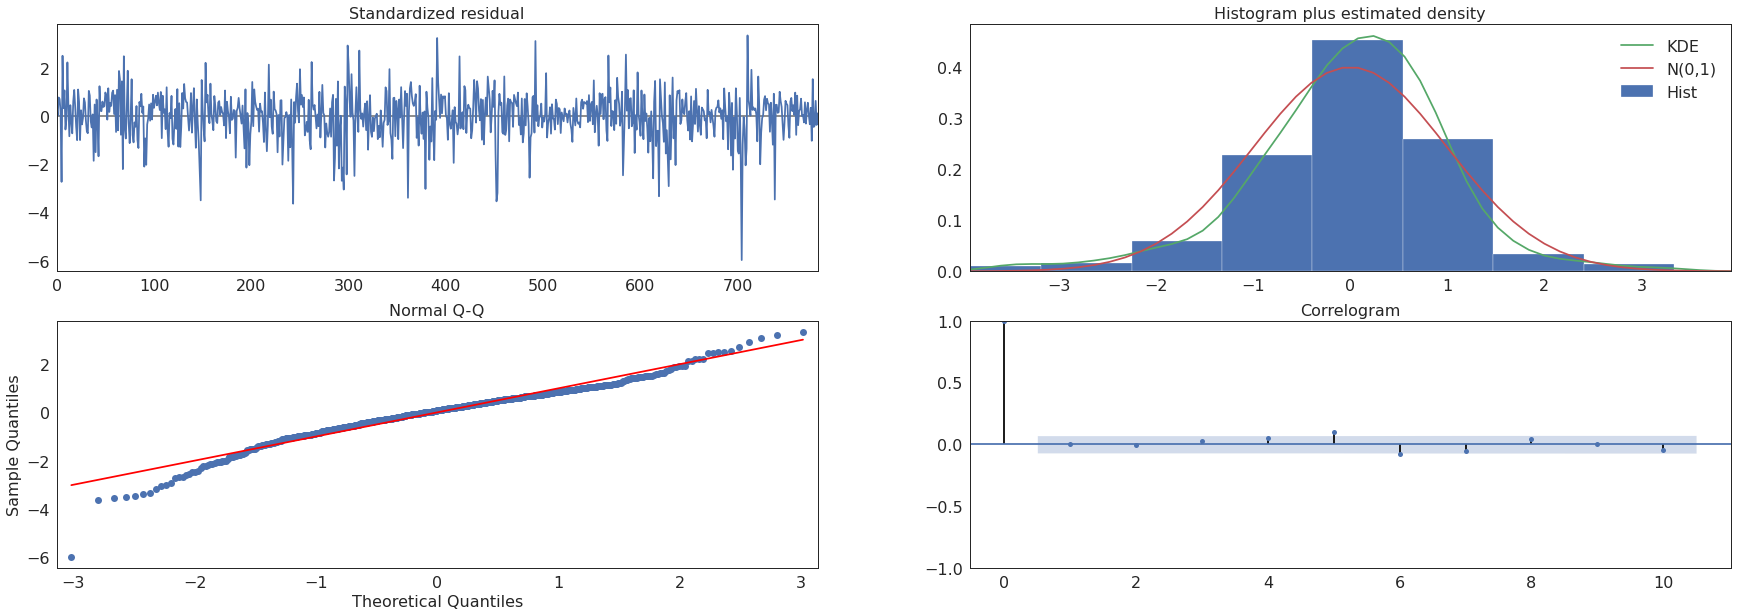

In [ ]:
model.plot_diagnostics(figsize=(30,10));

In [ ]:
forecasts, confint = model.predict(test.shape[0], return_conf_int=True)  # predikcija N koraka u buducnost sa intervalima pouzdanosti

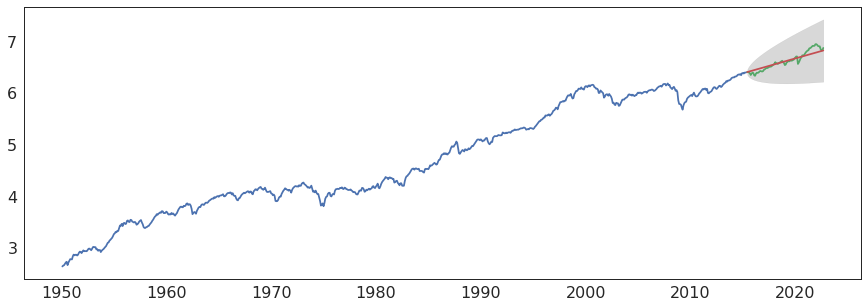

In [ ]:
cf = pd.DataFrame(confint)
prediction_series = pd.Series(forecasts,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train)
ax.plot(test)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [ ]:
rev_train = inv_boxcox(train, lmb)
rev_test = inv_boxcox(test, lmb)
rev_predictions = inv_boxcox(prediction_series, lmb)
rev_confint = inv_boxcox(confint, lmb)

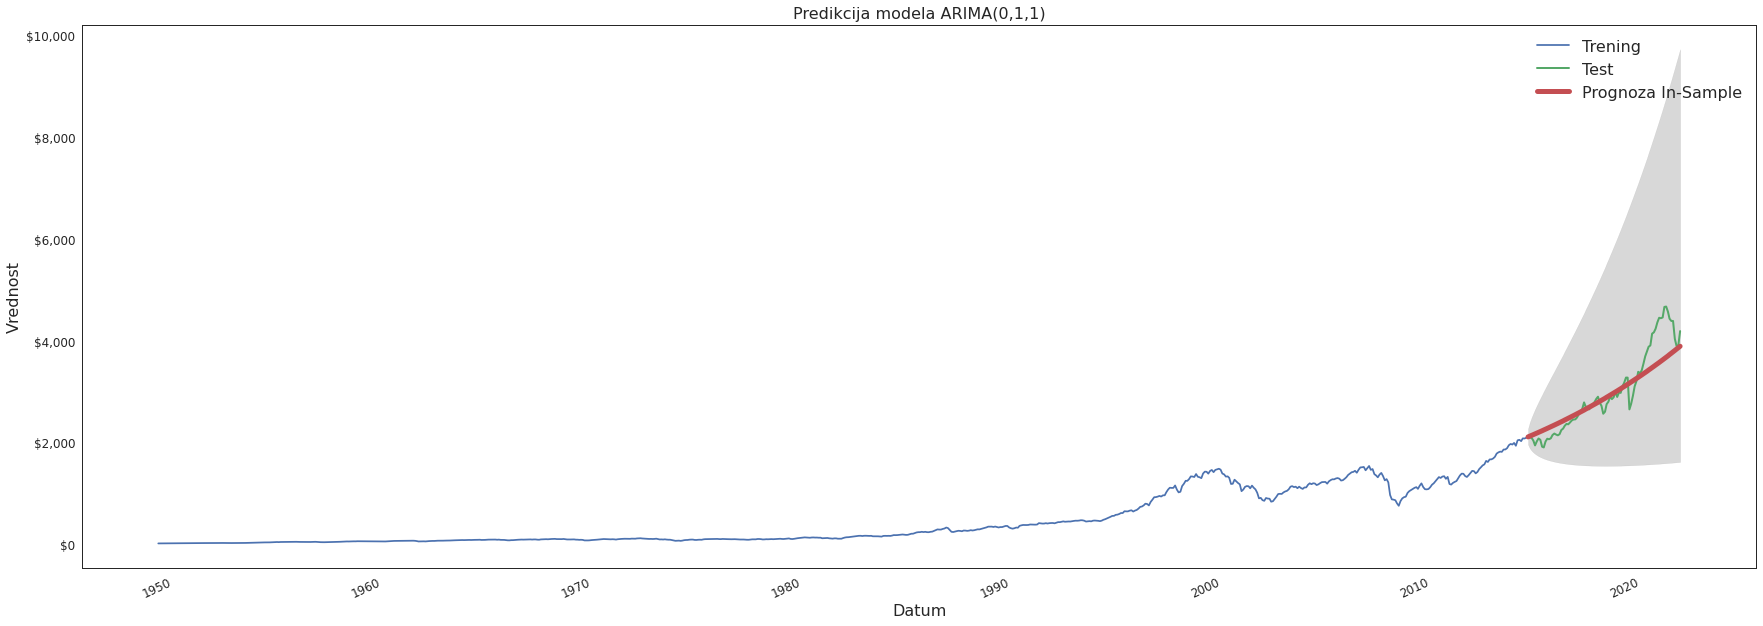

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
cf = pd.DataFrame(rev_confint)

ax.plot(rev_train, label="Trening")
ax.plot(rev_test, label="Test", linewidth=2.0)
ax.plot(rev_predictions, label="Predikcija", linewidth=5.0)

ax.legend(["Trening", "Test", "Prognoza In-Sample",])
ax.set_title("Predikcija modela ARIMA(0,1,1)")
ax.set_xlabel("Datum")
ax.set_ylabel("Vrednost")

ax.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

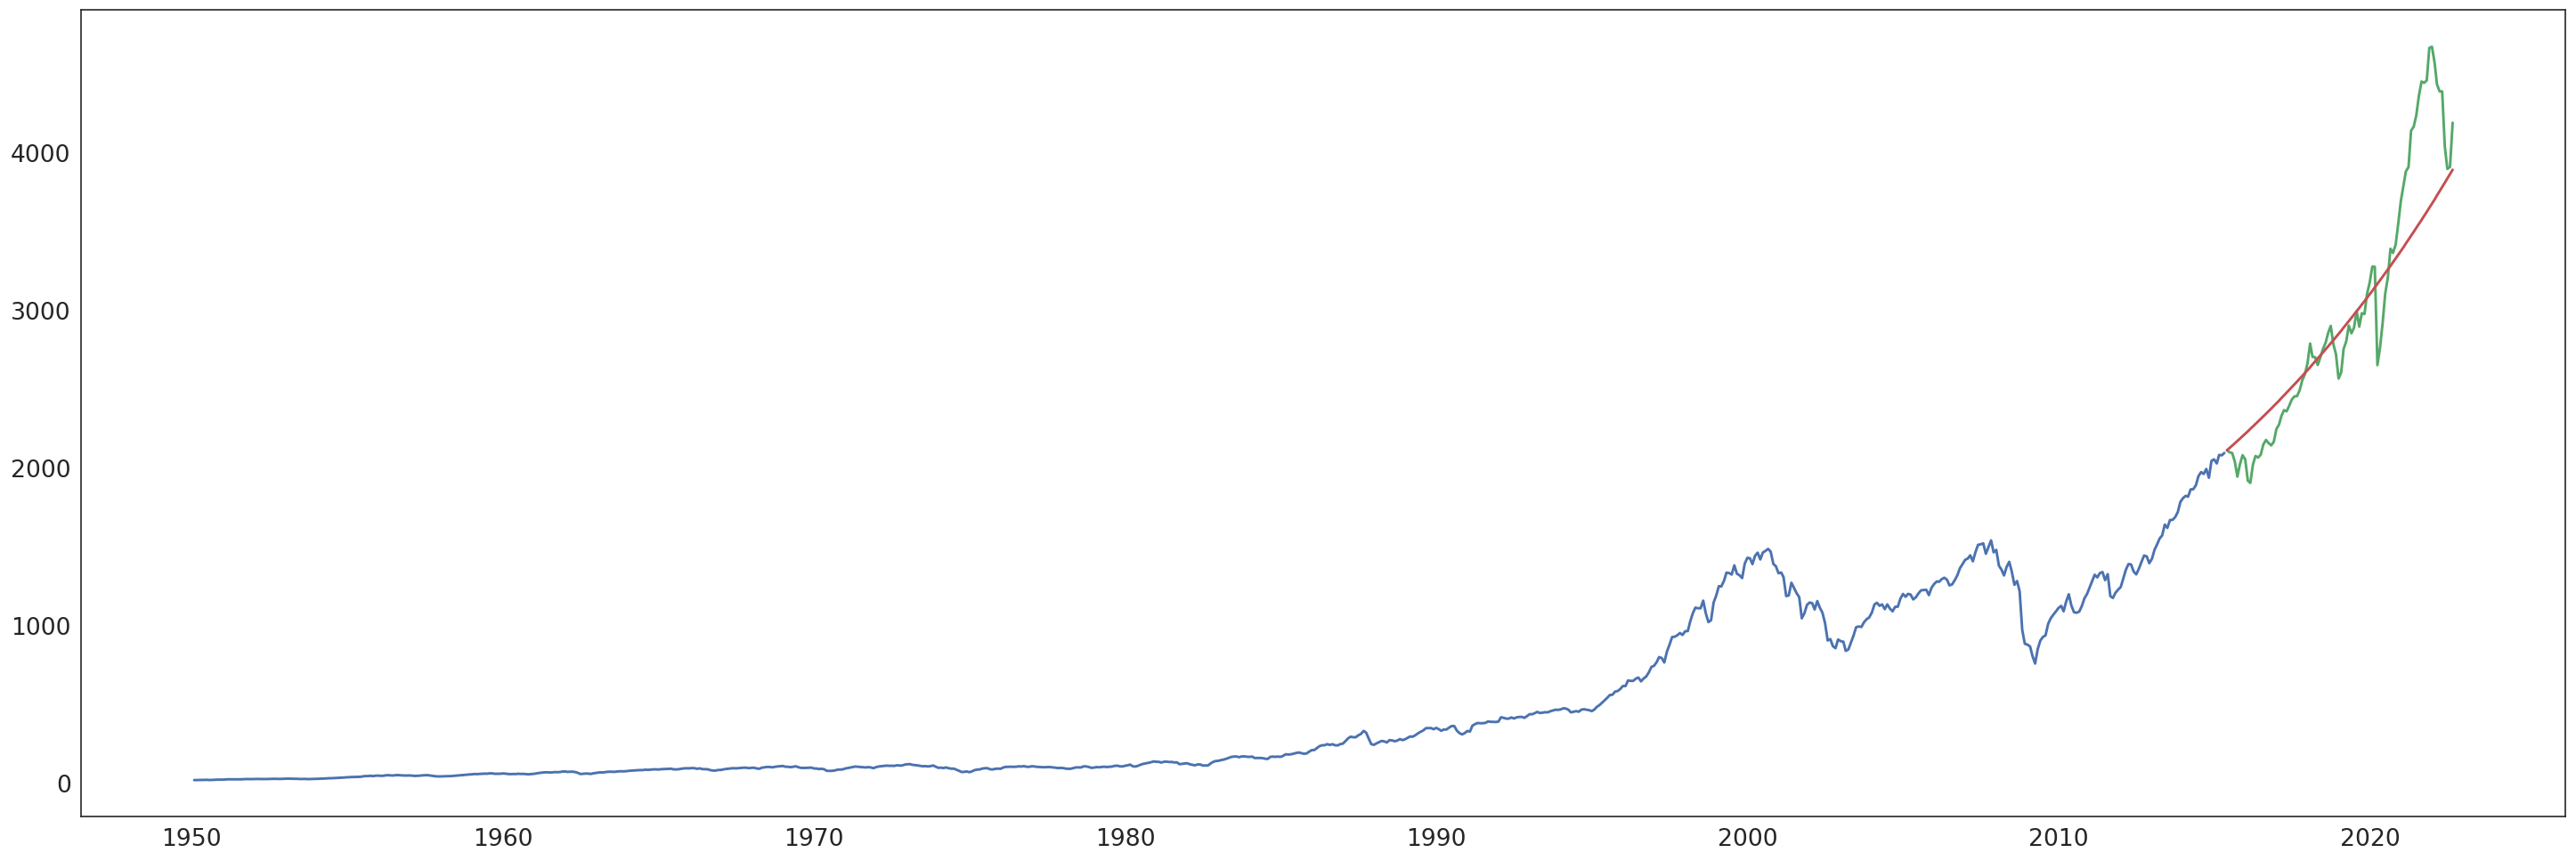

In [ ]:
fig, ax  = plt.subplots(figsize=(30,10), dpi=120)

ax.plot(rev_train)
ax.plot(rev_test)
ax.plot(rev_predictions)


In [ ]:
prediction_series_exp = np.exp(prediction_series)

mse = mean_squared_error(rev_test, rev_predictions)
print('MSE: '+str(mse))

mae = mean_absolute_error(rev_test, rev_predictions)
print('MAE: '+str(mae))

rmse = np.sqrt(mean_squared_error(rev_test, rev_predictions))
print('RMSE: '+str(rmse))

mape = mean_absolute_percentage_error(rev_test, rev_predictions)
print('MAPE: '+str(mape))

MSE: 124516.83153754062
MAE: 241.74137554749223
RMSE: 352.8694256202152
MAPE: 0.07396320386028096


**OUT OF SAMPLE Prognoza**

In [ ]:
months = pd.date_range(start='2022-08-31', end='2023-08-31', freq='M')

In [ ]:
model = pm.auto_arima(prices, test='adf', trace=True, supress_warnings=True, start_p=0, start_q=0, m=12, d=None, seasonal=False, start_P=0, D=0, error_action='ignore', stepwise=True)
model.summary()

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3833.187, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3879.490, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3883.832, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3806.911, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3881.956, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3881.993, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3878.469, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3866.726, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.992 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  872
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1944.916
Date:                Thu, 18 Aug 2022   AIC                          -3883.832
Time:                        11:19:32   BIC                          -3869.524
Sample:                             0   HQIC                         -3878.358
                                - 872                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0049      0.001      4.012      0.000       0.002       0.007
ma.L1          0.2502      0.028      9.081      0.000       0.196       0.304
sigma2         0.0007   2.08e-05     32.400      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               583.30
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.85
Prob(H) (two-sided):                  0.21   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

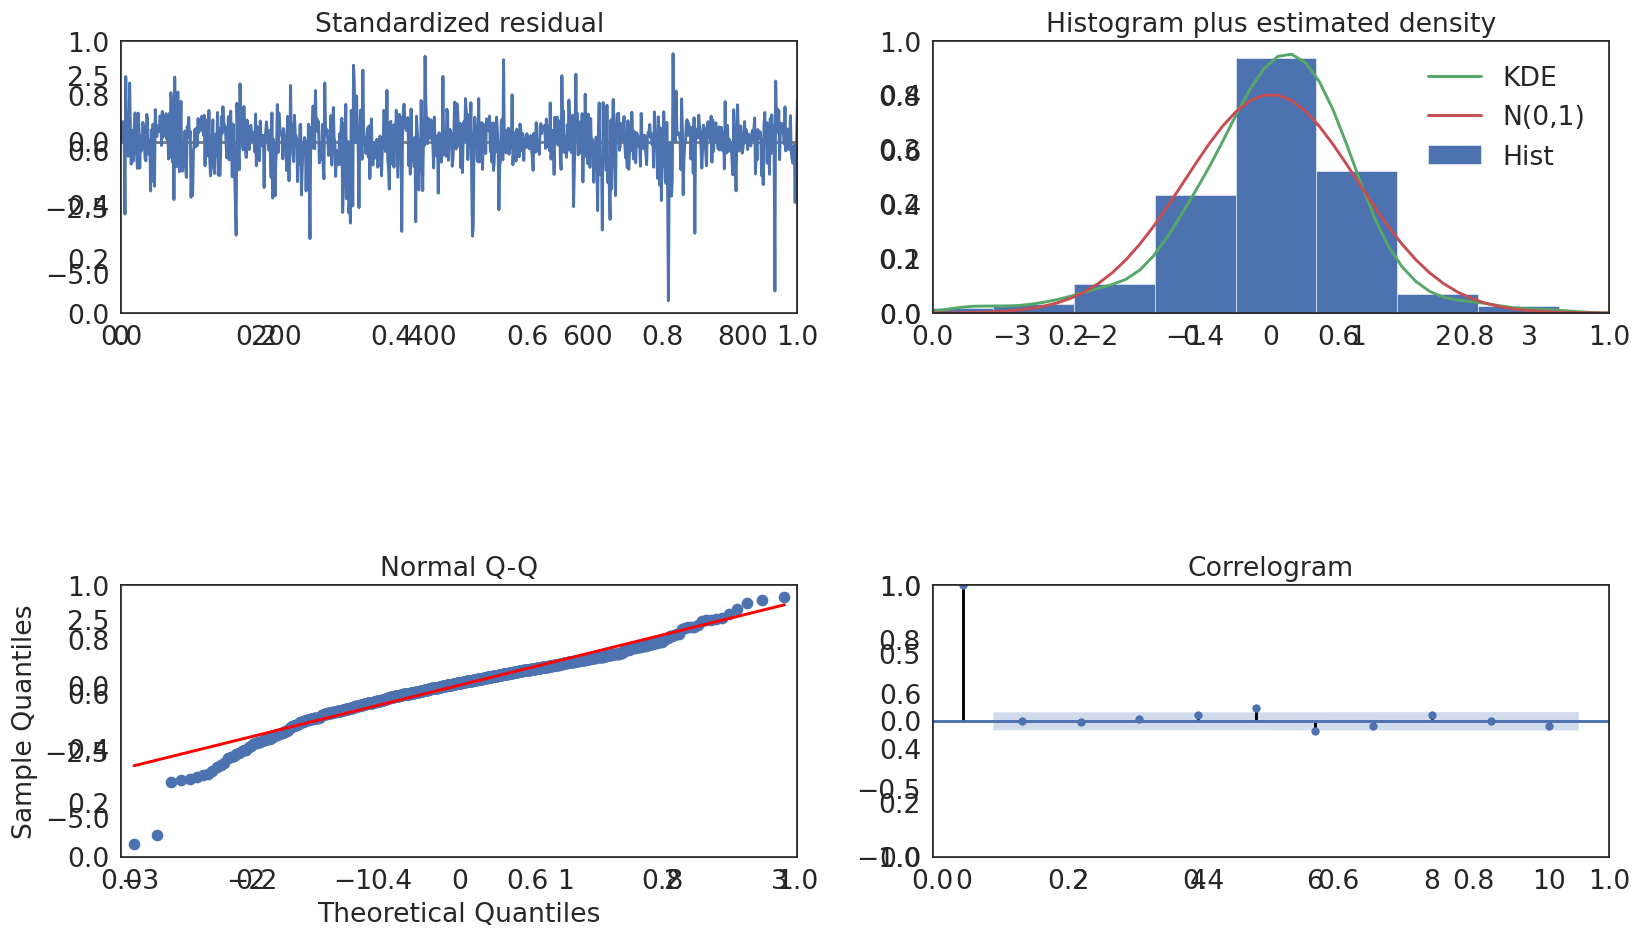

In [ ]:
fig, ax  = plt.subplots(2,2,figsize=(16,9), dpi=120)
fig.subplots_adjust(hspace=1);

model.plot_diagnostics(fig=fig);

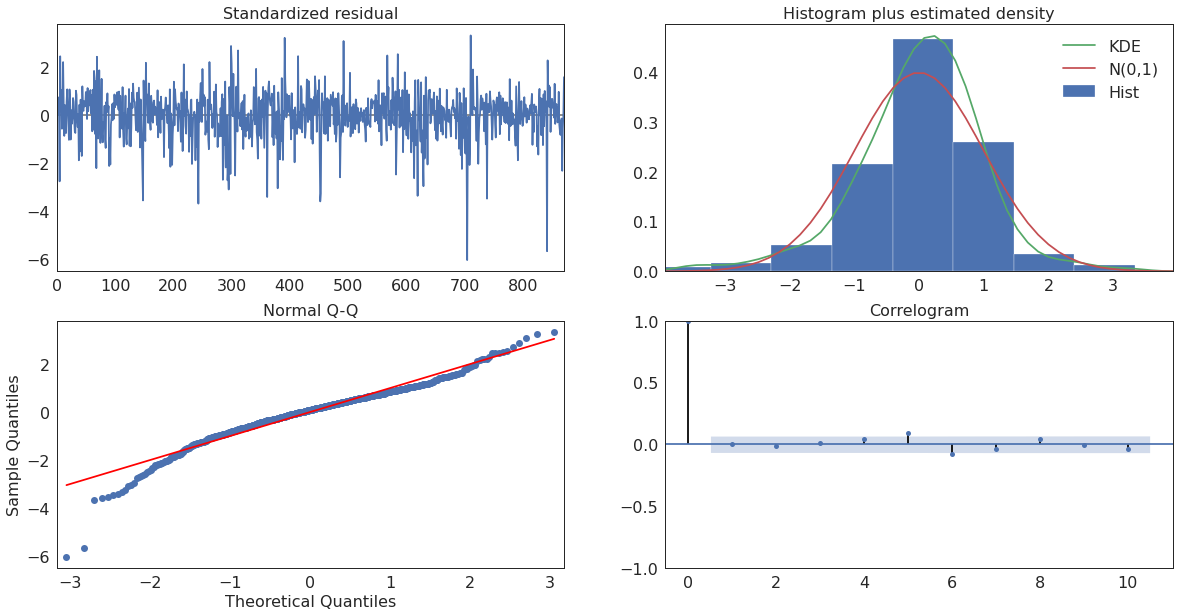

In [ ]:
model.plot_diagnostics(figsize=(20, 10));

In [ ]:
forecasts, confint = model.predict(len(months), return_conf_int=True)  # predikcija N koraka u buducnost sa intervalima pouzdanosti

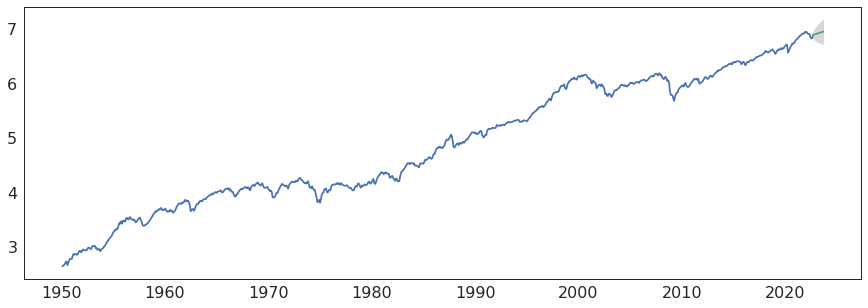

In [ ]:
cf = pd.DataFrame(confint)
prediction_series = pd.Series(forecasts,index=months)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(prices)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

Inverzija Box-Cox transformacije

In [ ]:
rev_train = inv_boxcox(train, lmb)
rev_test = inv_boxcox(test, lmb)
rev_predictions = inv_boxcox(prediction_series, lmb)
rev_prices = inv_boxcox(prices, lmb)
rev_confint = inv_boxcox(confint, lmb)

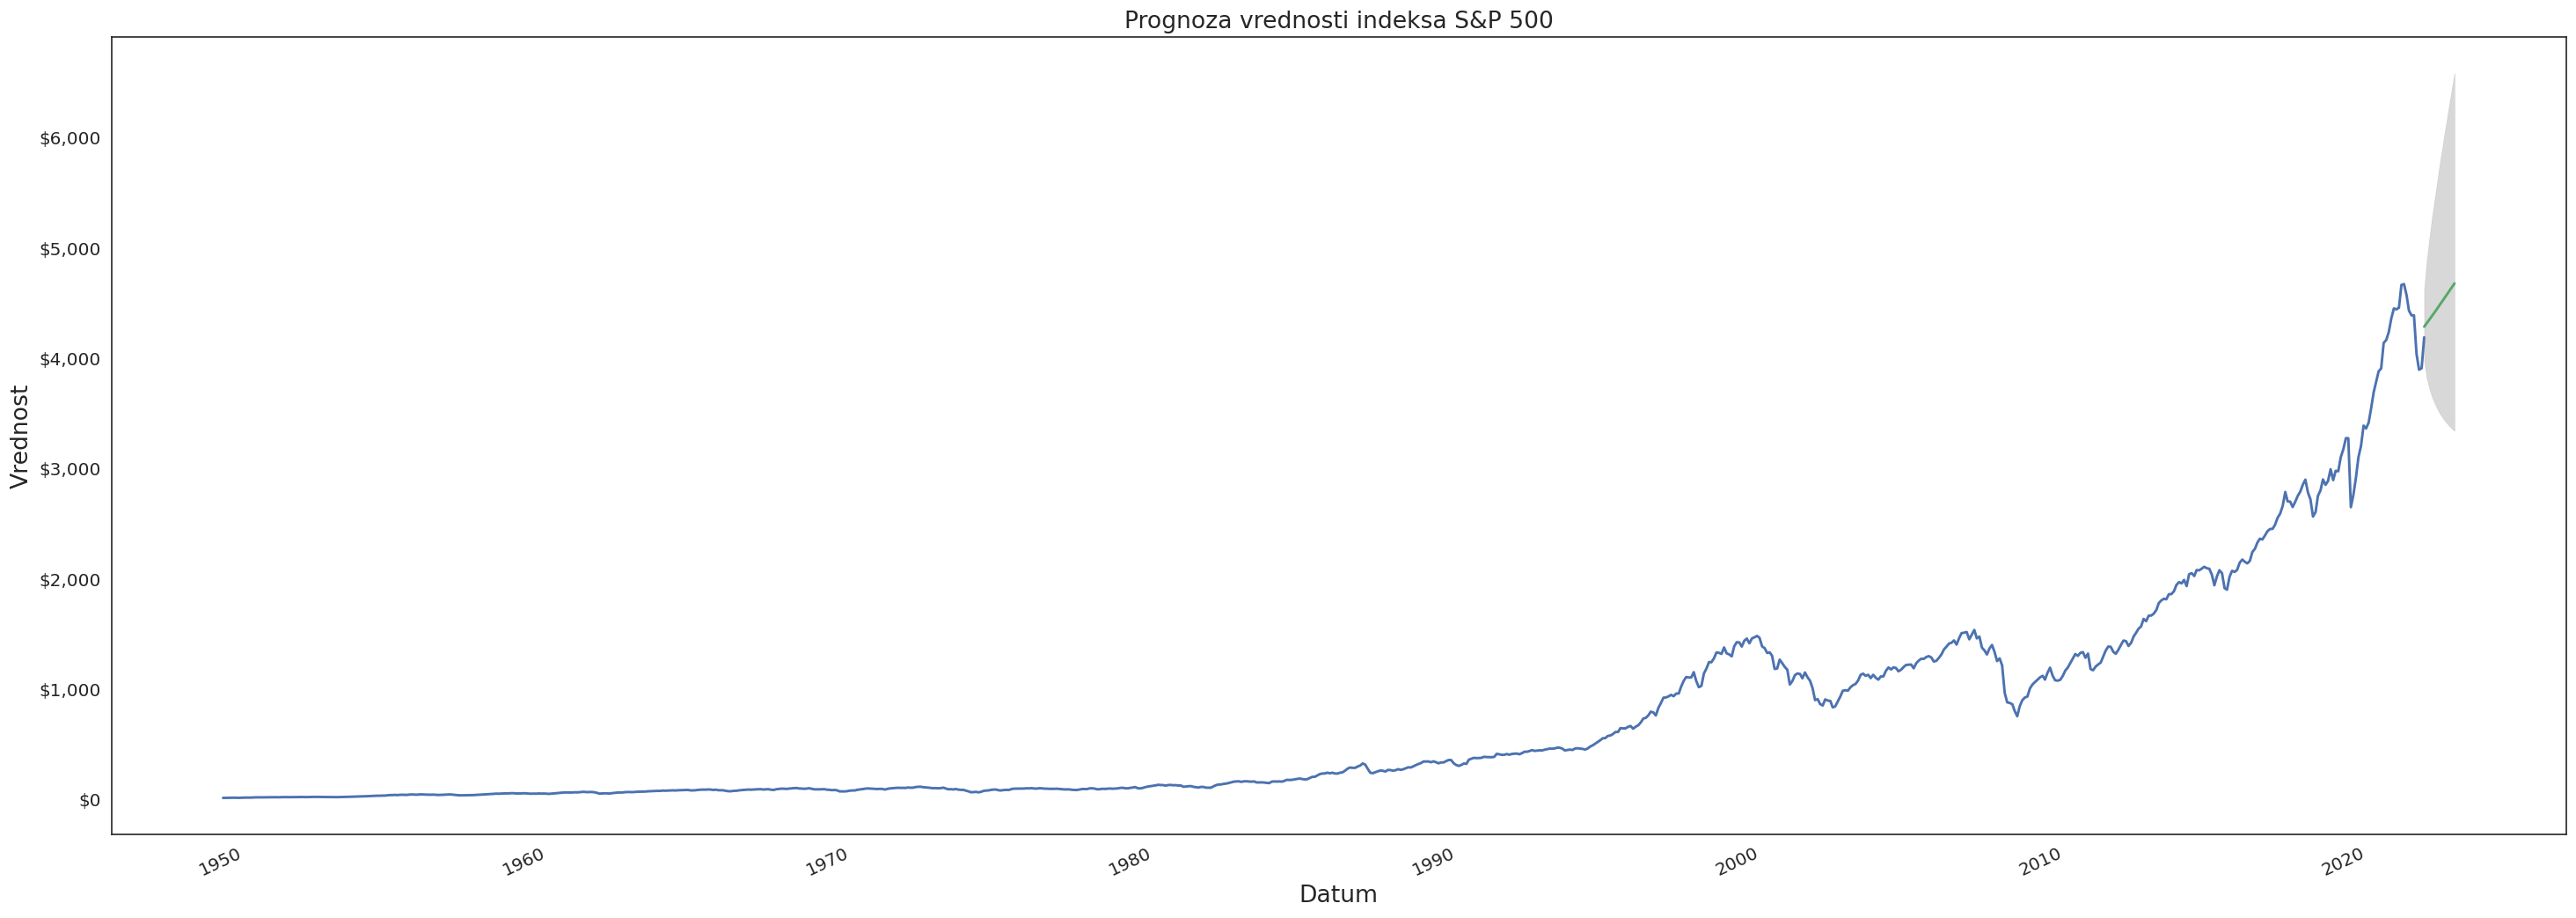

In [ ]:
fig, ax  = plt.subplots(figsize=(30,10), dpi=120)
cf = pd.DataFrame(rev_confint)

ax.plot(rev_prices, label="Istorijska cena")
ax.plot(rev_predictions)

ax.set_title("Prognoza vrednosti indeksa S&P 500")
ax.set_xlabel("Datum")
ax.set_ylabel("Vrednost")

ax.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [ ]:
rev_predictions

2022-08-31    4288.622803
2022-09-30    4319.933990
2022-10-31    4351.484842
2022-11-30    4383.277278
2022-12-31    4415.313233
2023-01-31    4447.594660
2023-02-28    4480.123526
2023-03-31    4512.901814
2023-04-30    4545.931527
2023-05-31    4579.214681
2023-06-30    4612.753311
2023-07-31    4646.549469
2023-08-31    4680.605223
Freq: M, dtype: float64

In [ ]:
cf

,0,1
0,3975.417773,4627.786487
1,3826.398503,4880.595168
2,3730.937351,5081.060868
3,3658.984838,5259.247293
4,3600.972806,5424.737000
5,3552.401811,5582.043999
6,3510.737278,5733.717608
7,3474.388713,5881.363237
8,3442.282888,6026.069208
9,3413.656631,6168.613965


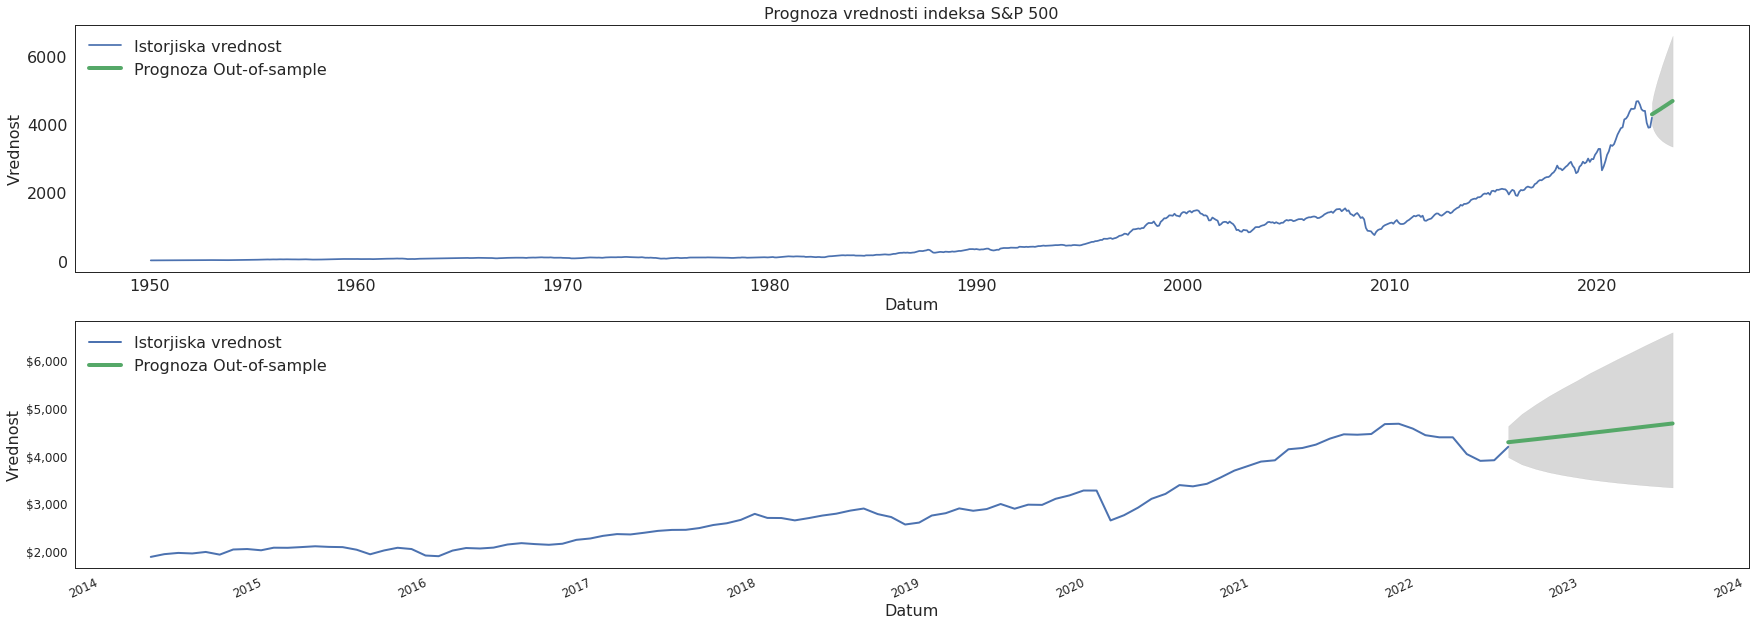

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30,10))

cf = pd.DataFrame(rev_confint)
ax1.plot(sp500Month)

ax1.plot(rev_predictions,linewidth=4.0)
ax1.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
ax1.legend(["Istorjiska vrednost", "Prognoza Out-of-sample"], loc='upper left')

ax1.set_title("Prognoza vrednosti indeksa S&P 500")
ax1.set_xlabel("Datum")
ax1.set_ylabel("Vrednost")


ax2.plot(rev_prices[-100:], label="Istorijska cena",linewidth=2.0)
ax2.plot(rev_predictions,linewidth=4.0)

ax2.set_xlabel("Datum")
ax2.set_ylabel("Vrednost")
ax2.legend(["Istorjiska vrednost", "Prognoza Out-of-sample"], loc='upper left')

ax2.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax2.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

ax2.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

fig.show()

In [ ]:
prediction_series_exp = np.exp(prediction_series)

mse = mean_squared_error(rev_test, rev_predictions)
print('MSE: '+str(mse))

mae = mean_absolute_error(rev_test, rev_predictions)
print('MAE: '+str(mae))

rmse = np.sqrt(mean_squared_error(rev_test, rev_predictions))
print('RMSE: '+str(rmse))

mape = mean_absolute_percentage_error(rev_test, rev_predictions)
print('MAPE: '+str(mape))